## Import Libraries

In [1]:
import torch
import math

from torch import optim
from torch import Tensor

from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt


from scipy.signal import butter,lfilter

## Load the data for Project n°1

In [2]:
import dlc_bci as bci
train_input, train_target = bci.load(root =  './data_bci', train=True, one_khz=True)

print(str(type(train_input)), train_input.size())
print(str(type(train_target)), train_target.size())
test_input, test_target = bci.load(root =  './data_bci', train=False, one_khz=True)
print(str(type(test_input)), test_input.size())
print(str(type(test_target)), test_target.size())

<class 'torch.FloatTensor'> torch.Size([316, 28, 500])
<class 'torch.LongTensor'> torch.Size([316])
<class 'torch.FloatTensor'> torch.Size([100, 28, 500])
<class 'torch.LongTensor'> torch.Size([100])


In [41]:
plt.plot(np.transpose(Variable(train_input).data.numpy()[0]));

RuntimeError: Variable data has to be a tensor, but got Variable

## Normalization (by hand)

In [4]:
train_moy = train_input.mean(dim=2).expand(train_input.size(2),train_input.size(0),train_input.size(1)).transpose(0,1).transpose(1,2)
train_std = train_input.std(dim=2).expand(train_input.size(2),train_input.size(0),train_input.size(1)).transpose(0,1).transpose(1,2)
train_input = train_input.sub_(train_moy).div(train_std) #center and reduce

test_moy = test_input.mean(dim=2).expand(test_input.size(2),test_input.size(0),test_input.size(1)).transpose(0,1).transpose(1,2)
test_std = test_input.std(dim=2).expand(test_input.size(2),test_input.size(0),test_input.size(1)).transpose(0,1).transpose(1,2)
test_input = test_input.sub_(test_moy).div(test_std) #center and reduce

## Add the channel dimension

In [5]:
train_input = train_input.view(train_input.size(0),1,train_input.size(1),-1)
test_input = test_input.view(test_input.size(0),1,test_input.size(1),-1)

In [6]:
train_input.shape

torch.Size([316, 1, 28, 500])

In [7]:
train_input, test_input, train_target, test_target = Variable(train_input), Variable(test_input), Variable(train_target), Variable(test_target)

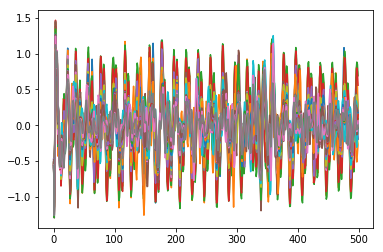

In [42]:
plt.plot(np.transpose(train_input.data.numpy()[0][0]));

In [9]:
nb_train_signals = train_input.shape[0]
nb_channels = train_input.shape[1]
nb_electrodes = train_input.shape[2] #There was a small error in Thibault's code here, corrected here
print('nb_train_signals = ', nb_train_signals, ', nb_channels = ', nb_channels, ', nb_electrodes = ', nb_electrodes)
mini_batch_size = 8

nb_train_signals =  316 , nb_channels =  1 , nb_electrodes =  28


## Create the architecture of the NN

In [ ]:
class Flatten(nn.Module):
    def forward(self,input):
        return input.view(mini_batch_size, -1)

In [ ]:
def create_model():
    return nn.Sequential(
        nn.Conv2d(in_channels = nb_channels, out_channels = 4, kernel_size = (1,21),stride=2),
        nn.ReLU(),
        #nn.MaxPool2d(kernel_size = (1,2)),
        nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size = (1,11),stride=2),
        nn.ReLU(),
        #nn.MaxPool2d(kernel_size = (1,2)),
        nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (1,11),stride=2),
        nn.ReLU(),
        #nn.MaxPool1d(kernel_size = 3),
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (1,11)),
        nn.ReLU(),
        nn.Conv2d(in_channels = 32, out_channels = 4, kernel_size = (1,11)),
        nn.ReLU(),
        
        Flatten(),
        nn.BatchNorm1d(528),
        nn.Linear(528,300), 
        nn.ReLU(),
        nn.Linear(300,2),
        nn.Softmax(dim=1))

In [ ]:
def train_model(model, train_input, train_target):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    nb_epochs = 100

    for e in range(0, nb_epochs):
        for b in range(math.ceil(train_input.size(0)/mini_batch_size)):
            if ((b+1)*mini_batch_size < train_input.size(0)):
                output = model(train_input.narrow(0, b*mini_batch_size, mini_batch_size))
                loss = criterion(output, train_target.narrow(0, b*mini_batch_size, mini_batch_size))
            else:
                #que du sale mamen
                output = model(train_input.narrow(0, train_input.size(0)-mini_batch_size, mini_batch_size))
                loss = criterion(output, train_target.narrow(0, train_input.size(0)-mini_batch_size, mini_batch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()

######################################################################

def compute_nb_errors(model, data_input, data_target):

    nb_data_errors = 0

    for b in range(math.ceil(data_input.size(0)/mini_batch_size)):
        if ((b+1)*mini_batch_size < data_input.size(0)):
            output = model(data_input.narrow(0, b*mini_batch_size, mini_batch_size))
            _, predicted_classes = torch.max(output.data, 1)
        else:
            output = model(data_input.narrow(0, data_input.size(0)-mini_batch_size, mini_batch_size))
            _, predicted_classes = torch.max(output.data, 1)
        
        for k in range(0, mini_batch_size):
            if data_target.data[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors

In [ ]:
model = create_model()

In [ ]:
train_model(model, train_input, train_target)
nb_test_errors = compute_nb_errors(model, test_input, test_target)
nb_train_errors = compute_nb_errors(model, train_input, train_target)
print('test error = {:0.2f}% {:d}/{:d} and train error = {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                                                     nb_test_errors, test_input.size(0),
                                                                                     (100 * nb_train_errors) / train_input.size(0),
                                                                                     nb_train_errors, train_input.size(0)))
print('With a batch size of {}' .format(mini_batch_size))

In [ ]:
conv1 = nn.Conv2d(in_channels = nb_channels, out_channels = 4, kernel_size = (1,21),stride=2)
conv2 = nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size = (1,11),stride=2)
conv3 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (1,11),stride=2)
conv4 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (1,11))
conv5 = nn.Conv2d(in_channels = 32, out_channels = 4, kernel_size = (1,11))

In [ ]:
np.shape(conv5(conv4(conv3(conv2(conv1(train_input.narrow(0,0,8)))))).view(8,-1))

In [ ]:
output = model(train_input.narrow(0, train_input.size(0)-mini_batch_size, mini_batch_size))

In [ ]:
output

# To compare with scikit results

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

In [11]:
# taking out the channel dimension
train_data = np.squeeze(train_input.data.numpy(), axis=1)
test_data = np.squeeze(test_input.data.numpy(), axis=1)
train_labels = train_target.data.numpy()
test_labels = test_target.data.numpy()

## Preprocess signal

In [12]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [13]:
fs = 1000 #1kHz

#bandpass filter between 40 and 400hz
for i in range(len(train_data)):
    for j in range(nb_electrodes):
        train_data[i,j] = butter_bandpass_filter(train_data[i,j], 40,400,fs)
for i in range(len(test_data)):
    for j in range(nb_electrodes):
        test_data[i,j] = butter_bandpass_filter(test_data[i,j], 40,400,fs)
        

#rectification
train_data = np.abs(train_data)
test_data = np.abs(test_data)


#lowpass filtering to maintain only the envelope of signal
for i in range(len(train_data)):
    for j in range(nb_electrodes):
        train_data[i,j] = butter_lowpass_filter(train_data[i,j], 20, fs)
for i in range(len(test_data)):
    for j in range(nb_electrodes):
        test_data[i,j] = butter_lowpass_filter(test_data[i,j], 20,fs)


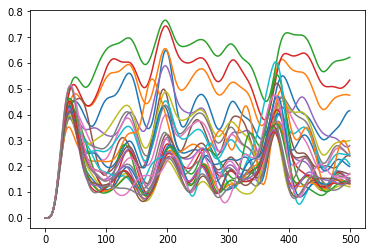

In [40]:
plt.plot(np.transpose(train_data[0]));

In [18]:
MAV_train = np.mean(np.abs(train_data),axis=2) #mean absolute value
MAV_test = np.mean(np.abs(test_data),axis=2)

In [19]:
NSC_train = np.sum(np.diff(np.sign(np.diff(train_data,axis=2)),axis=2)!=0,axis=2) #number of slope changes
NSC_test = np.sum(np.diff(np.sign(np.diff(test_data,axis=2)),axis=2)!=0,axis=2)

In [20]:
WL_train = np.sum(np.abs(np.diff(train_data,axis=2)),axis=2) #waveform length
WL_test = np.sum(np.abs(np.diff(test_data,axis=2)),axis=2)

In [21]:
total_data_train = np.concatenate((MAV_train,NSC_train,WL_train),axis=1)
total_data_test = np.concatenate((MAV_test,NSC_test,WL_test),axis=1)

In [25]:
np.shape(total_data_train)

(316, 84)

In [27]:
LDA = LinearDiscriminantAnalysis()

trainedLDA = LDA.fit(total_data_train, train_labels)

In [28]:
score_train = trainedLDA.score(total_data_train, train_labels)
score_test = trainedLDA.score(total_data_test, test_labels)

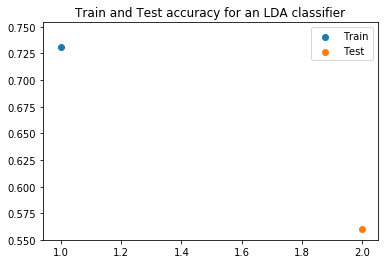

In [39]:
scat1 = plt.scatter([1],[score_train])
scat2 = plt.scatter([2],[score_test])
plt.title('Train and Test accuracy for an LDA classifier')
plt.legend((scat1,scat2),('Train','Test'))
plt.show()